Found 626 images belonging to 8 classes.
Found 5615 images belonging to 8 classes.
Epoch 1/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.3045 - loss: 2.1265 - val_accuracy: 0.3305 - val_loss: 1.8179
Epoch 2/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2812 - loss: 1.8655 - val_accuracy: 0.3333 - val_loss: 1.6559
Epoch 3/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.3563 - loss: 1.7366 - val_accuracy: 0.3264 - val_loss: 2.0017
Epoch 4/4
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2500 - loss: 2.1081 - val_accuracy: 0.3333 - val_loss: 1.8402


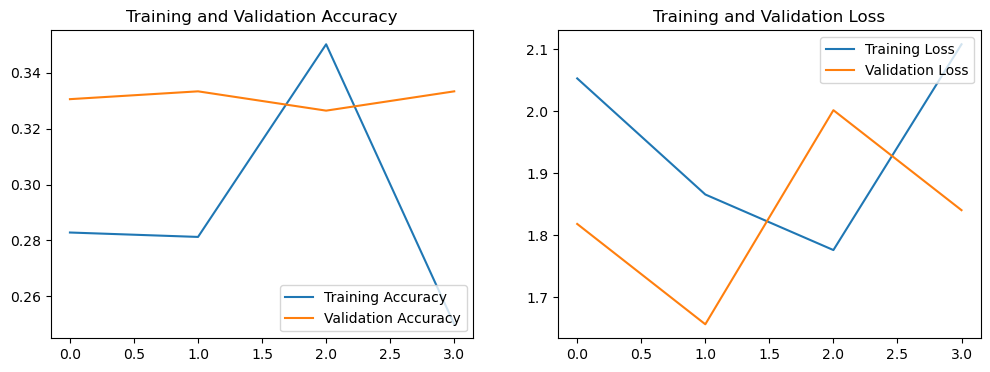

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# 设置数据目录（替换为你的数据集路径）
data_dir = 'CV_data/CV_data'
batch_size = 32
img_height = 224
img_width = 224
 
# 划分数据集（80%训练，20%验证）
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.9)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # 使用训练集
)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # 使用验证集
)

# 加载预训练的ResNet50模型，不包括顶部的全连接层
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# 冻结所有卷积层
for layer in base_model.layers:
    layer.trainable = False

# 添加自定义的全连接层
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# 构建最终的模型
model = Model(inputs=base_model.input, outputs=predictions)

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 设置回调函数以保存最佳模型和提前停止训练
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=4,  # 可以根据需要调整
    callbacks=[checkpoint, early_stopping]
)

# 绘制准确率和损失折线图
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
